## 8. Overview of Linear Modeling for Deblurring Quality Prediction

In this section, we analyze how visual properties of images (e.g., size, contrast, edges) affect deblurring quality as measured by the Structural Similarity Index (SSIM) metric. The goal is to understand the extent to which the intrinsic features of an image explain the variability of SSIM.

We build a linear regression model to predict SSIM from features such as contrast, size, and edge strength. We evaluate the goodness-of-fit of the model using R² and adjusted R², and test whether the model's assumptions (linearity, normality of residuals, constant variance) are met.

To do this, we import the libraries needed to manipulate data (pandas, numpy), visualize relationships (matplotlib, seaborn), and build statistical models (statsmodels).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
sns.set_theme(style="whitegrid")

METRIC = "ssim"

## Data Integration and Preprocessing for Regression Modeling

In this step, we load two datasets:

- One contains image features like size, contrast, edge strength, etc.
- The other contains deblurring performance metrics generated by DeblurGANv2.

We merge these datasets using the unique image key so that each row combines both the visual characteristics and the corresponding deblurring results.

To simplify the analysis, we also compute the average SSIM across different types of blur (box, gaussian, motion) and use it as a single quality metric.  
Finally, we remove rows with missing values to ensure the dataset is clean and ready for statistical modeling.


In [2]:
from common.config import IDPA_DATASET, DEBLURGANV2_DATASET

df_method = pd.read_parquet(DEBLURGANV2_DATASET)
df_original = pd.read_parquet(IDPA_DATASET)
df = pd.merge(df_original, df_method, on="key", how="inner")
df[METRIC] = df[[f"{METRIC}_box", f"{METRIC}_gaussian", f"{METRIC}_motion"]].mean(axis=1)
df = df.dropna()
df.head()

,url,category,key,width,height,exif,aspect_ratio,size,rms_contrast,sobel_edge_strength,...,gmsd_box,ssim_gaussian,psnr_gaussian,lpips_gaussian,gmsd_gaussian,ssim_motion,psnr_motion,lpips_motion,gmsd_motion,ssim
0,http://411posters.com/wp-content/uploads/2011/...,poster,000000382,1300.0,1728.0,{},0.752315,3169036.0,0.373365,54.414061,...,0.288099,0.659350,21.244109,0.008100,0.253387,0.654728,20.551406,0.010522,0.206268,0.620810
1,http://a.mktgcdn.com/p/0LhPt4Nq5I-vk_mT8U64np5...,withchar,000000931,1680.0,1120.0,{},1.500000,3369749.0,0.302635,61.659178,...,0.227861,0.738023,22.569502,0.002756,0.150001,0.540615,19.870651,0.020393,0.219148,0.619503
2,http://a1.espncdn.com/photo/2012/1113/mag_odog...,complex,000000558,2048.0,1280.0,{},1.600000,3899907.0,0.220292,60.462335,...,0.270982,0.743597,20.932284,0.020868,0.231691,0.765259,21.149544,0.007956,0.189855,0.710448
3,http://alphabuildersgroup.com/wp-content/uploa...,map,000001226,1645.0,1515.0,{},1.085809,1469928.0,0.256979,52.038717,...,0.275775,0.803767,20.027765,0.006226,0.248356,0.757785,18.665515,0.052418,0.247961,0.763774
4,http://aniaames.co.uk/wp-content/uploads/2017/...,people,000000225,1600.0,1067.0,"{""Image Make"": ""Canon"", ""Image Model"": ""Canon ...",1.499531,2598543.0,0.184612,46.895873,...,0.182107,0.949705,33.129541,0.013915,0.062373,0.852327,27.304294,0.008519,0.122539,0.849848


## Exploratory Analysis of Visual Predictors for Deblurring Quality (SSIM)

This section investigates the linear relationships between image-level visual features and deblurring performance, with a specific focus on the SSIM metric. The purpose is to identify the most predictive features to be included in subsequent regression models.

Two analytical tools are used:

- A **pairplot** for visual exploration of the association between `ssim_motion` and key features (e.g., contrast, edge strength, size).
- **Correlation and R² heatmaps** to numerically evaluate the strength and explanatory power of each relationship.

---

**Pairplot interpretation**

The pairplot reveals different patterns of association between `ssim_motion` and the selected features:

- **`rms_contrast`** shows a mild upward trend, suggesting that increased contrast may slightly enhance perceptual quality after deblurring. However, the trend is weak and the scatter of data points is wide, indicating low explanatory power.
- **`size`** appears largely unstructured, with no clear directional pattern, implying that overall image size is not strongly associated with SSIM in a linear fashion.
- **`sobel_edge_strength`** displays a pronounced negative linear relationship with SSIM. As the edge strength increases, SSIM tends to decrease. This may reflect that stronger edges introduce challenges for the deblurring model, such as over-sharpening or structural artifacts.
- **`canny_edge_density`** similarly shows a strong negative trend, with denser edges leading to lower SSIM scores. The spread is slightly larger than for sobel, but the downward slope is visually evident.

These plots provide qualitative confirmation that edge-related features (sobel and canny) are potentially strong predictors, while other features such as `size` or `contrast` might be less useful when considered in isolation.

---

**Pearson correlation heatmap**

Quantitative correlation analysis reinforces these visual observations:

- The strongest negative correlations with `ssim_motion` are observed for:
  - `canny_edge_density`: **−0.54**
  - `sobel_edge_strength`: **−0.52**
  - `motion_length`: **−0.37**
  - `size`: **−0.31**

These values suggest that images with more pronounced blur (longer motion), more edges (canny/sobel), or larger sizes tend to receive lower SSIM scores after deblurring. This may be due to increased structural complexity or difficulty in accurately reconstructing fine details.

- On the other hand, `rms_contrast` shows an extremely weak correlation near zero, indicating it does not meaningfully explain variation in SSIM by itself.

---

**R² heatmap interpretation**

By squaring the Pearson correlations, we obtain the R² values—these indicate how much of the **variance in SSIM** is explained by each feature individually.

- `canny_edge_density`: **R² ≈ 0.29**
- `sobel_edge_strength`: **R² ≈ 0.27**
- `motion_length`: **R² ≈ 0.14**
- `size`: **R² ≈ 0.10**
- `rms_contrast`: **R² ≈ 0.00**

These findings confirm that `canny_edge_density` and `sobel_edge_strength` are the most informative individual predictors of SSIM, each explaining nearly 30% of its variance. In contrast, features like `motion_angle`, `contrast`, and `width` contribute very little and are unlikely to improve model performance if included without interaction terms or non-linear transformations.

---

**Summary and implications**

- Edge-related features—specifically `canny_edge_density` and `sobel_edge_strength`—are the strongest individual predictors of deblurring performance, exhibiting consistent negative associations with SSIM.
- Motion-related features such as `motion_length` are moderately predictive, supporting the idea that longer blurs are harder to correct.
- Some features, such as image size, show weak associations, and others like `rms_contrast` show negligible influence.

These insights are instrumental for guiding feature selection. Prioritizing edge and motion descriptors is likely to yield more accurate and parsimonious regression models. Conversely, excluding features with low linear relevance may reduce model complexity without sacrificing predictive performance.



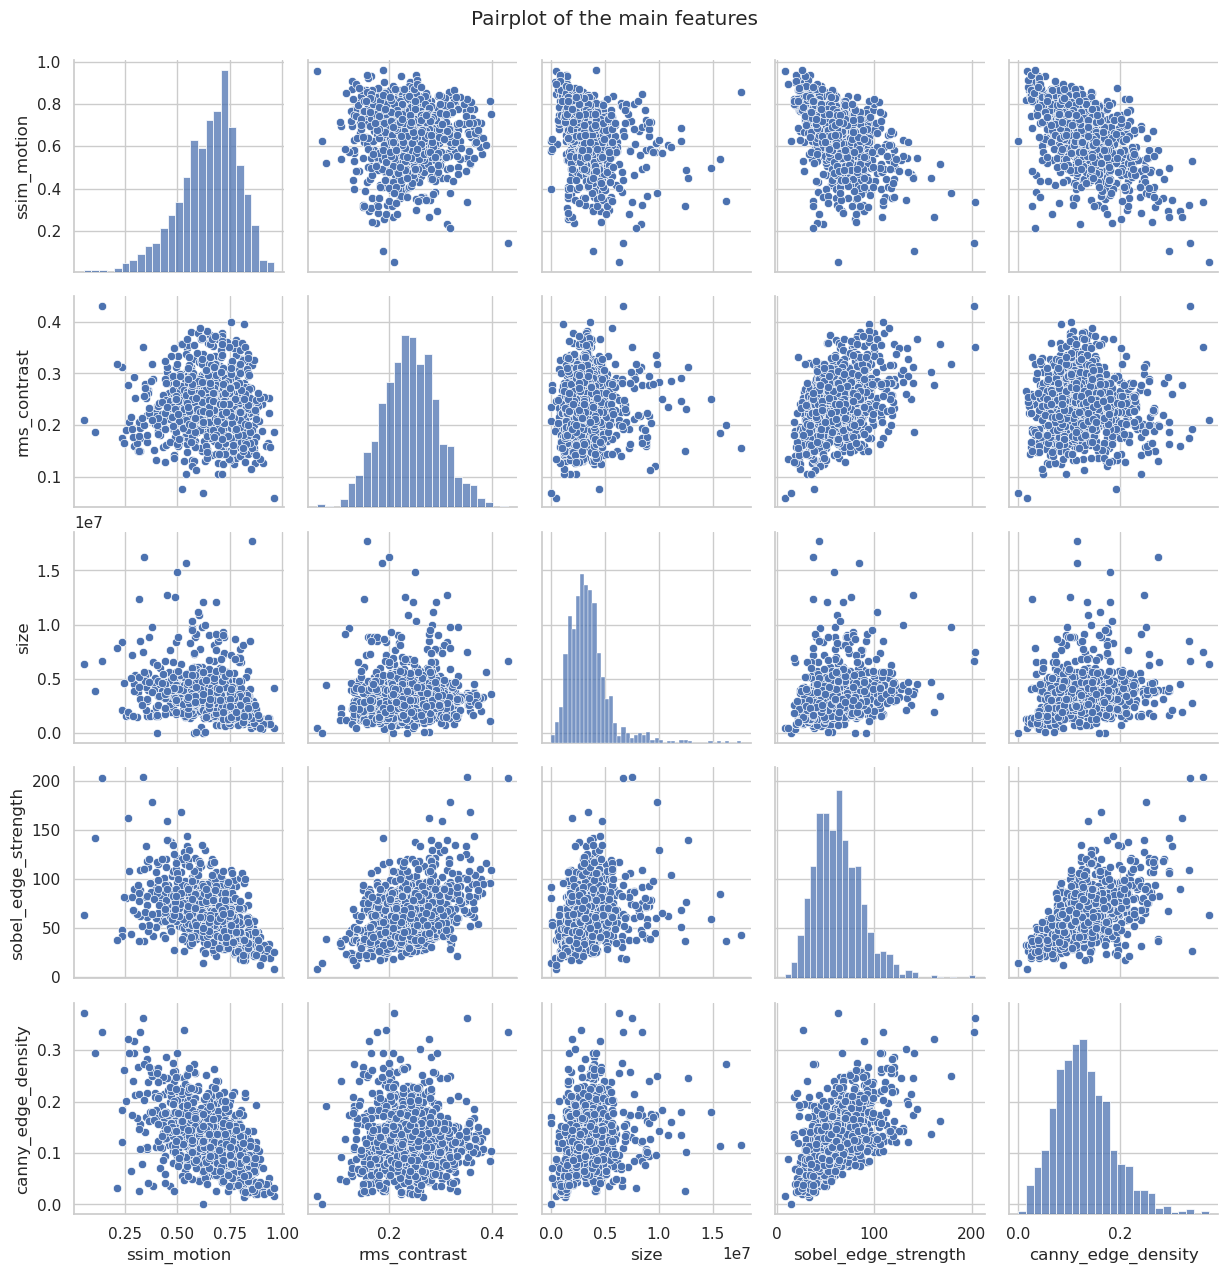

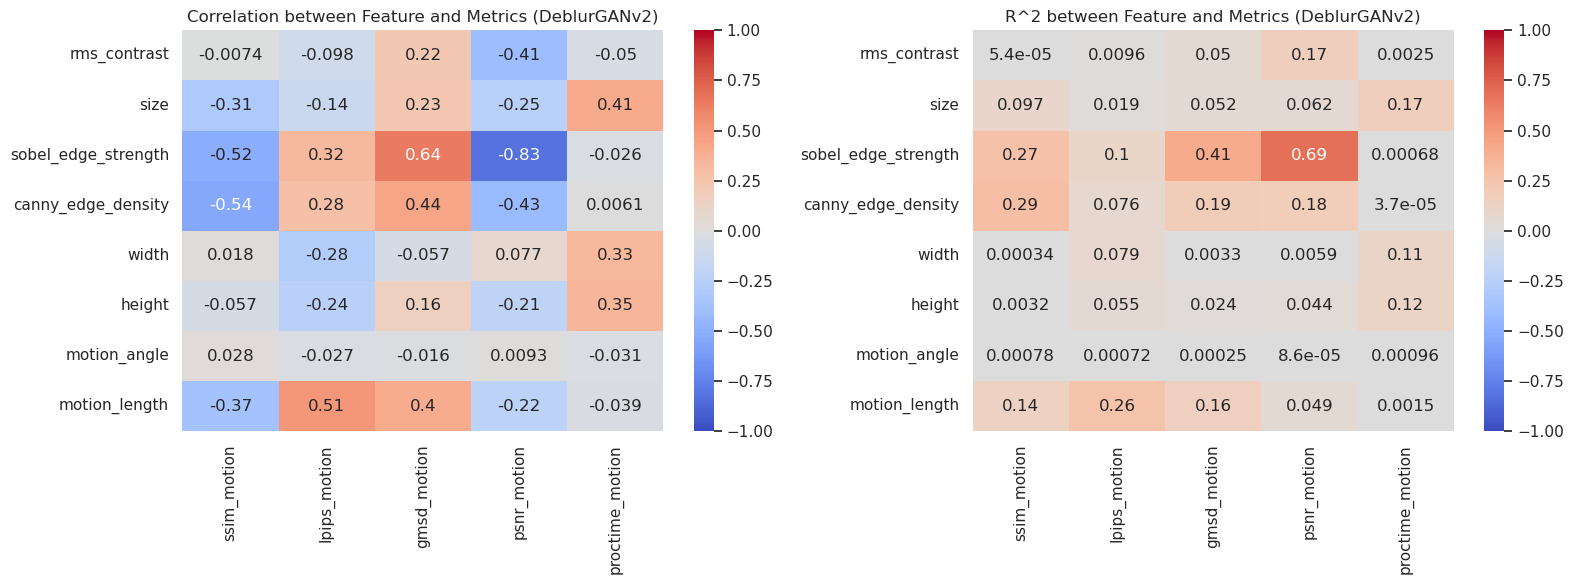

In [3]:
sns.pairplot(df[["ssim_motion", "rms_contrast", "size", "sobel_edge_strength", "canny_edge_density"]])
plt.suptitle("Pairplot of the main features", y=1.02)
plt.show()

features = ['rms_contrast', 'size', 'sobel_edge_strength', 'canny_edge_density', "width", "height", "motion_angle", "motion_length"]
metrics = ['ssim_motion', 'lpips_motion', 'gmsd_motion', 'psnr_motion', 'proctime_motion']

# Pearson correlation matrix between features and metrics
corr_df = df[features + metrics].corr()

# R^2 calculated by squaring the correlation
r_squared_df = corr_df ** 2

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(corr_df.loc[features, metrics], annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title('Correlation between Feature and Metrics (DeblurGANv2)')

sns.heatmap(r_squared_df.loc[features, metrics], annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title('R^2 between Feature and Metrics (DeblurGANv2)')

plt.tight_layout()
plt.show()

## Analysis of Deblurring Performance Across Image Categories

This section investigates how deblurring performance varies as a function of image content category. Each image in the dataset is associated with a predefined semantic category (e.g., *food*, *poster*, *complex*, *scenery*), and we compute the mean values of several quality metrics for each group.

The evaluated metrics include:

- **SSIM_motion**: Structural Similarity Index; higher values indicate better perceptual similarity to the original image.
- **LPIPS_motion** and **GMSD_motion**: Perceptual and gradient-based distortion metrics; lower values are desirable as they reflect reduced degradation.
- **PSNR_motion**: Peak Signal-to-Noise Ratio; higher values correspond to sharper reconstructions with less noise.
- **Proctime_motion**: Inference time; lower values indicate faster computational performance.

These metrics are visualized using a heatmap, facilitating comparative analysis across categories through intuitive color coding.

Several key trends emerge from the results. Categories such as *food*, *vehicle*, and *furniture* achieve consistently high SSIM scores (above 0.68), indicating that the deblurring model performs particularly well on images with structured or well-defined content. In contrast, categories such as *complex* and *scenery* exhibit substantially lower SSIM values (around 0.57), suggesting that the model struggles to reconstruct images with high texture complexity or chaotic spatial patterns. This observation is further corroborated by higher LPIPS and GMSD values for these same categories, implying greater perceptual distortion.

From a signal fidelity standpoint, *animal* and *food* categories attain higher PSNR values, indicative of more accurate pixel-level restoration. These results align with the SSIM findings and reinforce the conclusion that certain content types are inherently easier to restore.

In terms of computational efficiency, the majority of categories are processed in approximately **0.2–0.3 seconds**, indicating suitable performance for many real-time scenarios. However, the *furniture* category presents a notable outlier, with a mean processing time nearing **0.59 seconds**. This anomaly may be attributed to larger image resolutions, higher edge density, or other structural characteristics that increase the computational load.

In summary, the model demonstrates **superior performance on semantically simple or well-structured content**, while facing challenges on **highly textured or complex scenes**. Processing time is generally consistent across categories, with some exceptions that warrant further investigation. These insights are essential for assessing the model's generalizability and for informing future optimizations based on content-specific performance characteristics.



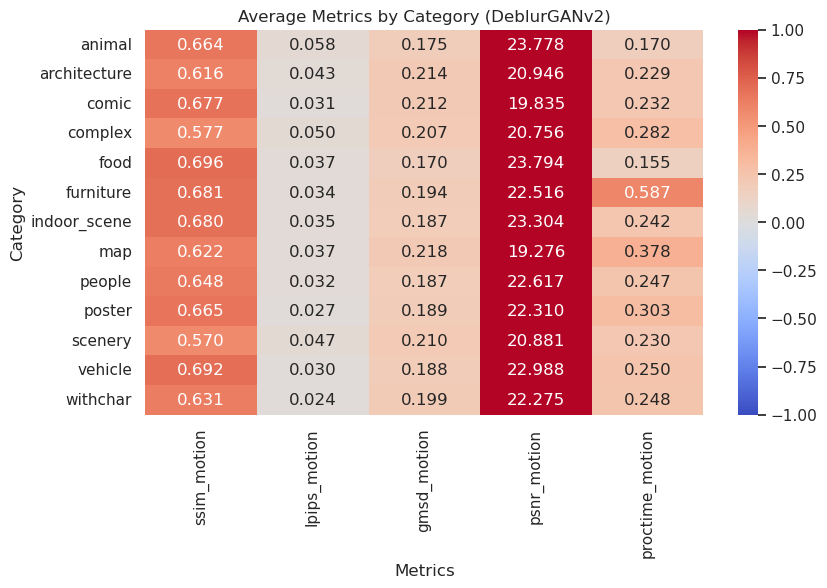

In [4]:
metrics = ['ssim_motion', 'lpips_motion', 'gmsd_motion', 'psnr_motion', 'proctime_motion']
category_means = df.groupby('category')[metrics].mean()

plt.figure(figsize=(9, 5))
sns.heatmap(category_means, annot=True, cmap="coolwarm", fmt=".3f", vmin=-1, vmax=1)
plt.title('Average Metrics by Category (DeblurGANv2)')
plt.ylabel('Category')
plt.xlabel('Metrics')
plt.show()

## Assessing Individual Blur Parameters via Simple Linear Regression

In this section, we explore how individual blur parameters affect the quality of the deblurred images. We focus on three specific inputs: `box_size` (kernel size of the box blur), `gaussian_sigma` (standard deviation for Gaussian blur), and `motion_length` (length of the motion blur). The idea is to see if these parameters influence the quality scores, such as SSIM or LPIPS.

To do that, we fit a simple linear regression for each feature–metric pair using the equation: **y = βx + α**, where `x` is the blur parameter and `y` is the quality score. The slope (β) tells us how much the score changes when the feature increases by 1. The intercept (α) is the predicted score when the feature is 0. We also compute **R²**, which tells us how much of the variation in the quality score is explained by that feature.

Then, we visualize the results: we plot the data points and overlay the fitted regression line. This gives us both a numeric and a visual understanding of the trend.

If the slope is positive, it means that increasing the blur parameter improves the quality metric (e.g., higher SSIM). A higher R² (close to 1) means that the feature is a strong predictor of image quality. If R² is low, the feature doesn't explain much.

This analysis helps us understand which individual features matter most for deblurring performance, and prepares us for later steps where we combine multiple features into a full regression model.


In [5]:
from common.config import IDPA_DATASET, DEBLURGANV2_DATASET

df_blur = pd.read_parquet(IDPA_DATASET)
df_gan = pd.read_parquet(DEBLURGANV2_DATASET)

df = pd.merge(df_blur, df_gan, on="key")

df["ssim"] = df[["ssim_box", "ssim_gaussian", "ssim_motion"]].mean(axis=1)

df = df.dropna(subset=["ssim", "gaussian_sigma", "box_size", "motion_length"])

In [6]:
def regression_and_plot(x, y, x_label, y_label, titolo):
    x = x.astype(float)
    y = y.astype(float)

    cov_xy = np.cov(x, y, ddof=1)[0, 1]
    var_x = np.var(x, ddof=1)
    beta = cov_xy / var_x
    alpha = y.mean() - beta * x.mean()

    y_pred = beta * x + alpha
    ss_res = ((y - y_pred) ** 2).sum()
    ss_tot = ((y - y.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot

    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, s=10, label="Dati")
    plt.plot(x, y_pred, color="red", label=f"y = {beta:.3f}x + {alpha:.3f}")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(titolo)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {"β (slope)": beta, "α (intercept)": alpha, "R²": r2}

### Simple Linear Regression: SSIM vs. Box Kernel Size

This analysis investigates the relationship between the size of the box blur kernel (`box_size`) and the deblurring quality, as measured by the Structural Similarity Index (SSIM). A simple linear regression model is employed to estimate how variations in kernel size influence SSIM values.

The fitted regression line (e.g., `y = 0.014x - 0.079`) indicates that for each unit increase in `box_size`, the SSIM increases on average by approximately 0.014. This positive slope suggests that larger kernels are generally associated with better reconstruction quality.

However, the observed data points show a notable degree of dispersion around the regression line, indicating that the relationship, while present, is relatively weak. The coefficient of determination (R²) quantifies this aspect: it represents the proportion of variance in SSIM that can be explained by changes in the kernel size. A low R² implies that the box blur kernel alone does not account for most of the variation in SSIM.

In conclusion, although the analysis reveals a positive linear trend between `box_size` and SSIM, the strength of this association is limited. This suggests that while increasing the kernel size may slightly enhance deblurring quality, other factors likely play a more substantial role in determining SSIM outcomes.


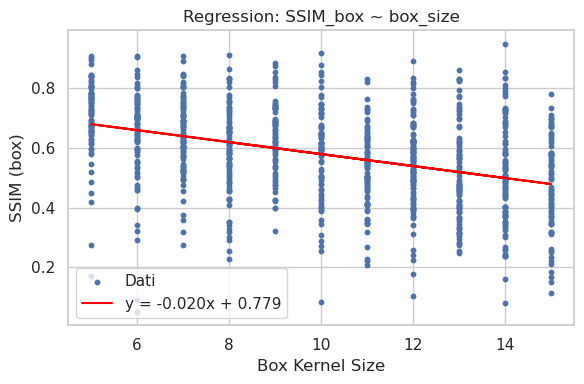

In [7]:
box_res = regression_and_plot(
    df["box_size"], df["ssim_box"],
    "Box Kernel Size", "SSIM (box)",
    "Regression: SSIM_box ~ box_size"
)


### Simple Linear Regression: SSIM vs. Gaussian Sigma

This analysis explores the influence of the Gaussian blur parameter, specifically the standard deviation (σ), on deblurring quality as measured by the Structural Similarity Index (SSIM). A simple linear regression model is used to assess the extent to which variations in σ affect the SSIM score.

The regression equation (e.g., `y = 0.043x - 0.048`) indicates a positive linear relationship: as σ increases, SSIM tends to increase as well. This suggests that images degraded using stronger Gaussian blur (i.e., larger σ values) are, on average, more effectively restored by the deblurring model.

Compared to the previous analysis involving box blur, the slope of the regression is steeper, implying a stronger effect of σ on SSIM. Nonetheless, the data points remain widely dispersed around the fitted line, highlighting the presence of substantial variability that is not captured by the linear model alone.

The coefficient of determination (R²) quantifies the explanatory power of σ in this context. A moderate R² value would indicate that while σ contributes meaningfully to SSIM variation, it is not the sole determinant of image quality after deblurring.

In summary, the results suggest a moderate positive correlation between Gaussian blur strength and SSIM. Higher σ values tend to lead to better deblurring results, but additional factors beyond σ are necessary to fully explain the variation in SSIM performance.



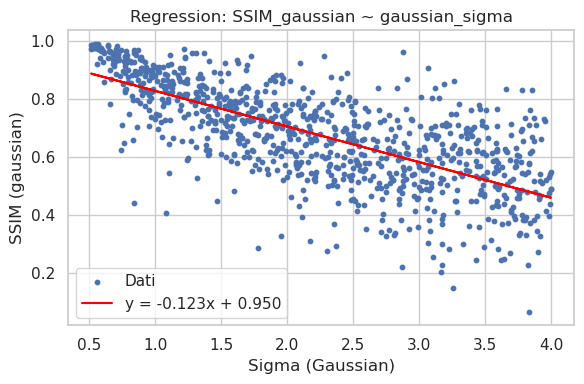

In [8]:
gauss_res = regression_and_plot(
    df["gaussian_sigma"], df["ssim_gaussian"],
    "Sigma (Gaussian)", "SSIM (gaussian)",
    "Regression: SSIM_gaussian ~ gaussian_sigma"
)


### Simple Linear Regression: SSIM vs. Motion Blur Length

This analysis investigates the relationship between the length of the applied motion blur (`motion_length`) and the resulting deblurring quality, measured using the Structural Similarity Index (SSIM). A simple linear regression model is applied to estimate the direction and magnitude of this relationship.

The regression equation reveals a small positive slope (β ≈ 0.003), indicating that as `motion_length` increases, the SSIM score tends to increase slightly. However, the effect size is minimal, suggesting only a marginal improvement in deblurring performance as the blur length grows.

The scatter plot of the data shows a considerable spread around the fitted regression line, highlighting a weak linear association. This observation is further supported by the coefficient of determination (R²), which is expected to be low. Such a value indicates that `motion_length` alone accounts for only a small fraction of the variability observed in SSIM scores.

In summary, while the direction of the relationship is positive, its strength is limited. The results suggest that `motion_length` exerts only a minor influence on deblurring quality, and that other image features—such as contrast or edge sharpness—may play a more significant role in determining SSIM performance.



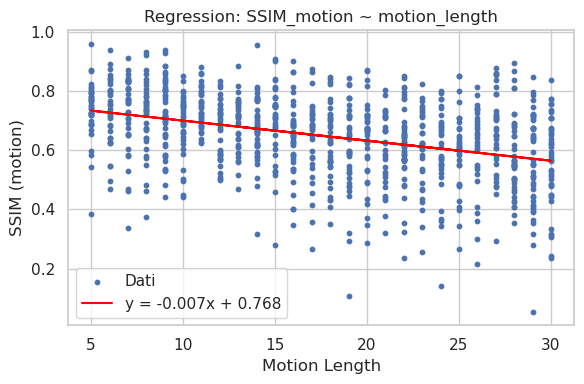

In [9]:
motion_res = regression_and_plot(
    df["motion_length"], df["ssim_motion"],
    "Motion Length", "SSIM (motion)",
    "Regression: SSIM_motion ~ motion_length"
)

### Comparative Summary of Blur Parameter Regressions

All three blur parameters exhibit a positive linear association with SSIM, suggesting that stronger or longer blur tends to result in higher SSIM after deblurring—possibly due to more pronounced structures being easier to reconstruct. However, Gaussian sigma provides the strongest predictive value, while motion length is the weakest.

The R² values, though moderate, indicate that none of the parameters alone fully explains SSIM outcomes. Thus, more complex models incorporating additional image features (e.g., edge statistics, content type) are required for higher predictive accuracy.

In [10]:
results = pd.DataFrame([box_res, gauss_res, motion_res], index=["Box", "Gaussian", "Motion"])
display(results)

,β (slope),α (intercept),R²
Box,-0.020039,0.779200,0.156699
Gaussian,-0.122783,0.949523,0.503126
Motion,-0.006775,0.768204,0.138137


## Baseline Multiple Linear Regression with Visual Features

In this analysis, we construct a multiple linear regression model to predict the quality of deblurred images, quantified using the Structural Similarity Index (SSIM). The model includes several numerical features that describe the intrinsic visual characteristics of each image, such as contrast, size, edge strength, and blur properties.

The primary objective is to evaluate the joint influence of these predictors on SSIM and to estimate the individual contribution of each feature while statistically controlling for the others. Model performance is assessed using standard regression diagnostics, including the coefficient of determination (R²), adjusted R², and the F-statistic for overall model significance.

The regression results show that the model explains approximately 58.8% of the variance in SSIM (R² = 0.588), with an adjusted R² of 0.584, which accounts for the number of predictors used. The high F-statistic and associated p-value (p < 0.001) indicate that the model is statistically significant overall, suggesting that the set of predictors provides meaningful explanatory power.

Analysis of the individual coefficients reveals that `rms_contrast` exerts a positive influence on SSIM, indicating that images with higher contrast tend to yield better deblurring results. Conversely, features such as `size`, `sobel_edge_strength`, `canny_edge_density`, and `motion_length` are negatively associated with SSIM, implying that images with large dimensions, high edge complexity, or stronger motion blur are more challenging to restore effectively.

The dimensions of the image (`width` and `height`) show positive coefficients, which may be attributed to the presence of more visual detail in higher-resolution images, facilitating better reconstruction. Importantly, the variable `motion_angle` is not statistically significant (p = 0.439), suggesting that, when controlling for other variables, it does not meaningfully contribute to explaining the variation in SSIM.

This model provides a robust baseline for understanding how various low-level image features relate to deblurring performance. It also highlights which features are most predictive of SSIM, offering valuable insight for further model refinement, such as incorporating categorical variables or applying feature selection techniques.


In [11]:
features = ['rms_contrast', 'size', 'sobel_edge_strength', 'canny_edge_density', "width", "height", "motion_angle", "motion_length"]
X = df[features]
y = df[f"{METRIC}_motion"]
X = add_constant(X)
model = sm.OLS(y, X).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ssim_motion   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     167.6
Date:                Thu, 29 May 2025   Prob (F-statistic):          3.41e-175
Time:                        18:36:15   Log-Likelihood:                 947.41
No. Observations:                 950   AIC:                            -1877.
Df Residuals:                     941   BIC:                            -1833.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.7273      0.025     29.463      0.000       0.679       0.776
rms_contrast            0.1888      0.066      2.863      0.004       0.059       0.318
size                 -4.75e-08   3.25e-09    -14.624      0.000   -5.39e-08   -4.11e-08
sobel_edge_strength    -0.0014      0.000     -7.670      0.000      -0.002      -0.001
canny_edge_density     -0.5749      0.067     -8.539      0.000      -0.707      -0.443
width                   0.0001   1.03e-05     10.852      0.000    9.17e-05       0.000
height                  0.0001   1.04e-05      9.717      0.000    8.09e-05       0.000
motion_angle         2.176e-05   2.81e-05      0.775      0.439   -3.34e-05    7.69e-05
motion_length          -0.0064      0.000    -16.628      0.000      -0.007      -0.006
==============================================================================
Omnibus:                      130.291   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              226.059
Skew:                          -0.870   Prob(JB):                     8.17e-50
Kurtosis:                       4.638   Cond. No.                     1.07e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regression Analysis with Categorical Predictors: Impact of Image Type on SSIM

This analysis explores the relationship between image content type and the quality of deblurring, as quantified by the Structural Similarity Index (SSIM). Each image in the dataset belongs to a categorical class—such as "comic", "map", "scenery", "people", among others—which represents the semantic content of the image. Since linear regression models require numerical inputs, the categorical variable `category` is encoded using one-hot encoding. This transformation creates a binary indicator (dummy) for each category, allowing the model to estimate a separate intercept shift for each image type relative to a reference category. To avoid perfect multicollinearity (the dummy variable trap), one category is omitted automatically (`drop_first=True`) and serves as the baseline for comparison.

The primary objective is to assess whether semantic image categories significantly influence the SSIM outcome after deblurring and to quantify the direction and magnitude of these effects. The model estimates the difference in average SSIM between each category and the reference class, while controlling for no other variables (i.e., this is a univariate model with multiple categorical predictors).

The regression output yields an R² value of 0.081 and an adjusted R² of 0.069. These values indicate that only approximately 8% of the variance in SSIM can be explained by image category alone. This is a relatively low proportion, suggesting that while image content type has a statistically significant effect on deblurring performance, it does not fully account for the variability observed in SSIM. Nonetheless, the overall F-statistic is highly significant (p < 0.001), confirming that the model is not trivial and that at least one of the categorical coefficients differs significantly from the baseline.

Inspection of the individual coefficients reveals that certain categories are consistently associated with lower SSIM values compared to the reference. For example:

- `scenery` has a coefficient of approximately -0.0935 and is statistically significant, indicating that images in this category tend to produce SSIM values nearly 0.09 units lower than the baseline on average. This suggests poor deblurring performance for natural landscape images, likely due to high textural variation and complexity.
- `complex` images also perform significantly worse, with a negative coefficient of about -0.0867, reflecting the difficulty of restoring scenes with intricate details and overlapping structures.
- `architecture` and `map` show moderate but statistically significant negative effects, possibly due to fine lines, dense edges, and structured patterns that are sensitive to blur and hard to reconstruct precisely.

In contrast, categories such as `people`, `comic`, `furniture`, and `indoor_scene` have coefficients that are not statistically different from zero (p-values > 0.05). This implies that the model does not detect meaningful differences in deblurring performance for these categories compared to the baseline. It is possible that these classes contain more homogeneous visual patterns or less edge density, making them easier to handle for the deblurring model.

In conclusion, this analysis demonstrates that semantic image content has a measurable but limited influence on SSIM outcomes. Categories characterized by high structural complexity, such as scenery and complex scenes, appear more challenging for the model, while simpler or more uniform categories yield similar results to the baseline. Although the explanatory power of the model is modest, these insights may inform future efforts to design content-aware deblurring methods or to augment training data with underperforming categories.




In [12]:
X_cat = pd.get_dummies(df['category'], drop_first=True).astype(float)
df_cat = pd.concat([X_cat, df[f"{METRIC}_motion"]], axis=1).dropna()
X = add_constant(df_cat.drop(f"{METRIC}_motion", axis=1))
y = df_cat[f"{METRIC}_motion"]
model_cat = sm.OLS(y, X).fit()
display(model_cat.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ssim_motion   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     6.874
Date:                Thu, 29 May 2025   Prob (F-statistic):           5.20e-12
Time:                        18:36:15   Log-Likelihood:                 566.68
No. Observations:                 950   AIC:                            -1107.
Df Residuals:                     937   BIC:                            -1044.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.6638      0.014     47.964      0.000       0.637       0.691
architecture    -0.0483      0.021     -2.332      0.020      -0.089      -0.008
comic            0.0128      0.020      0.646      0.519      -0.026       0.052
complex         -0.0867      0.021     -4.187      0.000      -0.127      -0.046
food             0.0320      0.021      1.535      0.125      -0.009       0.073
furniture        0.0171      0.021      0.808      0.419      -0.024       0.058
indoor_scene     0.0163      0.021      0.767      0.443      -0.025       0.058
map             -0.0419      0.020     -2.052      0.040      -0.082      -0.002
people          -0.0159      0.021     -0.758      0.449      -0.057       0.025
poster           0.0014      0.020      0.068      0.946      -0.038       0.041
scenery         -0.0935      0.022     -4.318      0.000      -0.136      -0.051
vehicle          0.0280      0.021      1.311      0.190      -0.014       0.070
withchar        -0.0328      0.027     -1.209      0.227      -0.086       0.020
==============================================================================
Omnibus:                       68.324   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.798
Skew:                          -0.664   Prob(JB):                     1.05e-18
Kurtosis:                       3.572   Cond. No.                         12.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Comprehensive Multiple Linear Regression Integrating Visual and Semantic Features

In this final analysis, a comprehensive multiple linear regression model is constructed to predict the SSIM metric following deblurring. This model integrates both numerical and categorical features to capture the joint effects of intrinsic image properties and semantic content types. Specifically, continuous variables such as contrast, image dimensions, edge characteristics, and motion blur parameters are included alongside categorical variables representing image categories (converted to binary dummy variables via one-hot encoding).

The purpose of this model is to evaluate the combined explanatory power of all available predictors and to assess the relative importance of each variable while controlling for the others. By incorporating both types of features, the model aims to produce a more robust and generalizable understanding of what drives deblurring quality as measured by SSIM.

The regression results indicate a coefficient of determination (R²) of 0.606, which means the model accounts for approximately 60.6% of the variance in SSIM scores across the dataset. This represents a modest improvement over models using only numeric predictors (R² = 0.588) or only categorical predictors (R² = 0.081). The adjusted R², which penalizes the inclusion of additional variables, remains high at 0.598—suggesting that the added complexity is justified by the improvement in model fit. Furthermore, the overall model is statistically significant, as confirmed by an F-statistic p-value well below 0.001.

The interpretation of individual coefficients provides insight into the effects of specific features:

- Among the **numerical predictors**, variables such as `motion_length`, `canny_edge_density`, `size`, and `sobel_edge_strength` exhibit significant negative associations with SSIM. This implies that images with stronger motion blur, greater edge density, or larger file sizes tend to be harder to deblur effectively. In contrast, `width` and `height` have positive coefficients, suggesting that higher-resolution images—presumably containing more detail—are more amenable to restoration. The variable `motion_angle` remains statistically non-significant, indicating that the orientation of motion blur does not meaningfully contribute to SSIM outcomes when other features are controlled for.

- Regarding the **categorical predictors**, several categories—namely `withchar`, `scenery`, `complex`, and `architecture`—are associated with significantly lower SSIM values compared to the reference class (the omitted baseline category). This finding reinforces earlier observations that certain types of visual content present greater challenges for deblurring algorithms, likely due to high structural complexity or texture variability. Other categories such as `poster`, `comic`, and `people` do not differ significantly from the baseline, suggesting a relatively neutral impact on SSIM performance in those cases.

An important technical consideration is the **condition number** of the model, which is reported to be on the order of 1.2 × 10⁸. This unusually high value indicates potential multicollinearity among the predictors—that is, some variables may be strongly correlated with each other. While multicollinearity does not undermine the model's predictive ability, it does complicate the interpretation of individual coefficients and suggests that care should be taken in assigning causal meaning to specific effects.

In summary, this full regression model offers a comprehensive perspective on the determinants of deblurring quality. It combines structural and semantic information to yield a predictive framework that outperforms simpler alternatives. While multicollinearity warrants caution, the model nonetheless provides valuable insights into which features—both visual and categorical—are most closely associated with successful image restoration.



In [13]:
X_full = pd.concat([df[features], pd.get_dummies(df['category'], drop_first=True).astype(np.float64)], axis=1)
df_full = pd.concat([X_full, df[f"{METRIC}_motion"]], axis=1).dropna()
X = add_constant(df_full.drop(f"{METRIC}_motion", axis=1))
y = df_full[f"{METRIC}_motion"]
model_full = sm.OLS(y, X).fit()
display(model_full.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ssim_motion   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     71.50
Date:                Thu, 29 May 2025   Prob (F-statistic):          3.54e-172
Time:                        18:36:15   Log-Likelihood:                 969.24
No. Observations:                 950   AIC:                            -1896.
Df Residuals:                     929   BIC:                            -1795.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.7402      0.026     28.765      0.000       0.690       0.791
rms_contrast            0.1050      0.072      1.455      0.146      -0.037       0.247
size                -4.747e-08   3.33e-09    -14.269      0.000    -5.4e-08   -4.09e-08
sobel_edge_strength    -0.0013      0.000     -6.630      0.000      -0.002      -0.001
canny_edge_density     -0.5475      0.072     -7.610      0.000      -0.689      -0.406
width                   0.0001   1.08e-05     11.575      0.000       0.000       0.000
height               9.762e-05   1.16e-05      8.407      0.000    7.48e-05       0.000
motion_angle         2.085e-05   2.79e-05      0.747      0.455   -3.39e-05    7.56e-05
motion_length          -0.0064      0.000    -16.816      0.000      -0.007      -0.006
architecture           -0.0285      0.014     -2.028      0.043      -0.056      -0.001
comic                   0.0236      0.016      1.521      0.129      -0.007       0.054
complex                -0.0365      0.014     -2.562      0.011      -0.064      -0.009
food                    0.0175      0.014      1.246      0.213      -0.010       0.045
furniture              -0.0286      0.015     -1.964      0.050      -0.057    -2.7e-05
indoor_scene           -0.0250      0.014     -1.727      0.084      -0.053       0.003
map                    -0.0203      0.015     -1.333      0.183      -0.050       0.010
people                 -0.0182      0.014     -1.266      0.206      -0.046       0.010
poster                 -0.0016      0.014     -0.113      0.910      -0.030       0.026
scenery                -0.0365      0.015     -2.479      0.013      -0.065      -0.008
vehicle                -0.0144      0.015     -0.984      0.325      -0.043       0.014
withchar               -0.0562      0.018     -3.081      0.002      -0.092      -0.020
==============================================================================
Omnibus:                      144.306   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              277.124
Skew:                          -0.907   Prob(JB):                     6.66e-61
Kurtosis:                       4.926   Cond. No.                     1.20e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##  Feature Selection via Forward Stepwise Regression for Optimal SSIM Prediction

In this section, we apply a **forward stepwise regression** procedure to automatically identify a subset of features that best predict the SSIM quality metric after deblurring. The goal is to build a model that maintains high predictive power while including only the most relevant variables.

Forward selection starts with an empty model and adds one variable at a time. At each step, the algorithm tests all remaining features and includes the one that provides the greatest improvement in **adjusted R²** — a version of R² that penalizes for the number of predictors. The process stops when no further variable addition improves the adjusted R².

The final model contains **16 variables**, and achieves an **adjusted R² of 0.598**, identical to the full model (which included all available predictors). The **standard R² is 0.605**, meaning that the selected features explain approximately **60.5% of the total variance** in the SSIM scores. This indicates that the reduced model performs **just as well as the full model**, but with fewer predictors — making it simpler and potentially more robust.

Among the selected variables, we find both numerical and categorical predictors. The **most important numerical features** are:
- `canny_edge_density`, `motion_length`, `sobel_edge_strength`, `size`, `width`, and `height`.

These features are consistent with previous findings: they have strong and statistically significant associations with SSIM. In particular, features related to **image structure** (such as edge strength and resolution) tend to be critical in explaining how well an image can be restored.

Regarding **categorical features** (i.e., image categories), only a subset of categories was retained:
- `comic`, `food`, `poster`, `withchar`, `complex`, and `scenery`.

This means that **not all image types significantly affect SSIM** once we account for numerical image properties. The included categories likely capture distinct visual patterns that interact with the deblurring process (e.g., texture, layout complexity).

This approach leads to a **more efficient and interpretable model**, with nearly the same predictive performance as the full model but less redundancy. It also reduces the risk of overfitting, as it avoids including weak or irrelevant predictors.

A technical note: the model has a **high condition number (~1.1e+08)**, suggesting potential **multicollinearity** — that is, some predictors may be strongly correlated with each other. While this does not invalidate the model's predictive ability, it means that **individual coefficient estimates may be unstable or hard to interpret**. For future analyses, techniques such as **normalization**, **variance inflation factor (VIF) analysis**, or **dimensionality reduction (e.g., PCA)** could help address this issue.

Overall, the forward selection procedure produces a compact, well-performing model that retains only the most informative features. It is a practical tool for simplifying complex regression problems while preserving statistical rigor and explanatory power.



In [14]:
def forward_selection(X, y):
    remaining = list(X.columns)
    selected = []
    current_adj_r2 = -float('inf')
    history = []

    while remaining:
        adj_r2_candidates = []
        models = []
        for candidate in remaining:
            vars_try = selected + [candidate]
            X_try = sm.add_constant(X[vars_try])
            model_try = sm.OLS(y, X_try).fit()
            adj_r2_candidates.append((candidate, model_try.rsquared_adj, model_try))
            models.append(model_try)
        # Select the variable that yields the highest adjusted R²
        best_candidate, best_adj_r2, best_model = max(adj_r2_candidates, key=lambda x: x[1])
        history.append((selected + [best_candidate], best_adj_r2))
        if best_adj_r2 > current_adj_r2:
            selected.append(best_candidate)
            remaining.remove(best_candidate)
            current_adj_r2 = best_adj_r2
            final_model = best_model
        else:
            break
    print("Forward selection history (variables, adjusted R2):")
    for vars_used, adjr2 in history:
        print(f"{len(vars_used)}: {list(vars_used)} Adj R2: {adjr2:.4f}")
    return final_model

model_back = forward_selection(X_full, df[f"{METRIC}_motion"])
display(model_back.summary())

Forward selection history (variables, adjusted R2):
1: ['canny_edge_density'] Adj R2: 0.2924
2: ['canny_edge_density', 'motion_length'] Adj R2: 0.4146
3: ['canny_edge_density', 'motion_length', 'sobel_edge_strength'] Adj R2: 0.4779
4: ['canny_edge_density', 'motion_length', 'sobel_edge_strength', 'size'] Adj R2: 0.5044
5: ['canny_edge_density', 'motion_length', 'sobel_edge_strength', 'size', 'width'] Adj R2: 0.5294
6: ['canny_edge_density', 'motion_length', 'sobel_edge_strength', 'size', 'width', 'height'] Adj R2: 0.5812
7: ['canny_edge_density', 'motion_length', 'sobel_edge_strength', 'size', 'width', 'height', 'comic'] Adj R2: 0.5882
8: ['canny_edge_density', 'motion_length', 'sobel_edge_strength', 'size', 'width', 'height', 'comic', 'food'] Adj R2: 0.5928
9: ['canny_edge_density', 'motion_length', 'sobel_edge_strength', 'size', 'width', 'height', 'comic', 'food', 'poster'] Adj R2: 0.5949
10: ['canny_edge_density', 'motion_length', 'sobel_edge_strength', 'size', 'width', 'height', 'c

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ssim_motion   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     89.27
Date:                Thu, 29 May 2025   Prob (F-statistic):          2.25e-175
Time:                        18:36:15   Log-Likelihood:                 967.69
No. Observations:                 950   AIC:                            -1901.
Df Residuals:                     933   BIC:                            -1819.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.7413      0.025     29.764      0.000       0.692       0.790
canny_edge_density     -0.5360      0.068     -7.869      0.000      -0.670      -0.402
motion_length          -0.0064      0.000    -16.899      0.000      -0.007      -0.006
sobel_edge_strength    -0.0014      0.000     -7.542      0.000      -0.002      -0.001
size                -4.694e-08    3.3e-09    -14.203      0.000   -5.34e-08   -4.05e-08
width                   0.0001   1.05e-05     11.599      0.000       0.000       0.000
height               9.332e-05   1.12e-05      8.296      0.000    7.12e-05       0.000
comic                   0.0381      0.012      3.049      0.002       0.014       0.063
food                    0.0277      0.012      2.320      0.021       0.004       0.051
poster                  0.0115      0.012      0.994      0.320      -0.011       0.034
withchar               -0.0442      0.016     -2.728      0.006      -0.076      -0.012
complex                -0.0236      0.012     -2.049      0.041      -0.046      -0.001
scenery                -0.0242      0.012     -1.958      0.050      -0.048    5.22e-05
rms_contrast            0.1083      0.068      1.590      0.112      -0.025       0.242
architecture           -0.0160      0.011     -1.405      0.160      -0.038       0.006
furniture              -0.0154      0.012     -1.307      0.191      -0.039       0.008
indoor_scene           -0.0128      0.012     -1.078      0.281      -0.036       0.010
==============================================================================
Omnibus:                      139.706   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              266.435
Skew:                          -0.884   Prob(JB):                     1.39e-58
Kurtosis:                       4.898   Cond. No.                     1.10e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regression Diagnostics: Validating OLS Assumptions

This section evaluates whether the key statistical assumptions underlying **Ordinary Least Squares (OLS) regression** are satisfied in the current model. Verifying these assumptions is critical to ensure the reliability and validity of the coefficient estimates, confidence intervals, and hypothesis tests.

Three primary assumptions are considered:

- **Linearity**: The relationship between the independent variables and the dependent variable (SSIM) must be linear.
- **Homoscedasticity**: The residuals (prediction errors) should have constant variance across all levels of the predicted values.
- **Normality of residuals**: The residuals should be approximately normally distributed, particularly for inference to be valid (e.g., p-values and confidence intervals).

To assess these assumptions, three diagnostic plots are examined:

1. **Histogram of Residuals with Density Curve**  
   This plot visualizes the distribution of the residuals. The shape appears approximately symmetric and bell-shaped, centered around zero. The residuals resemble a Gaussian distribution, supporting the assumption of **normality**. No clear skewness or heavy tails are observed, suggesting that standard inferential procedures are valid.

2. **Residuals vs Fitted Values Plot**  
   This scatter plot displays residuals on the y-axis and predicted SSIM values on the x-axis. In a well-specified model, these points should be randomly dispersed around the horizontal line at y = 0. Here, the residuals appear fairly homogeneously spread, with no systematic structure, curvature, or funnel-shaped patterns. This indicates that the assumptions of **linearity** and **homoscedasticity** are reasonably met. The absence of heteroscedasticity implies that model errors do not vary dramatically across levels of prediction.

3. **Normal Q-Q (Quantile-Quantile) Plot**  
   This plot compares the empirical quantiles of the residuals with the theoretical quantiles from a standard normal distribution. If the residuals are normally distributed, the points should lie approximately along the 45-degree reference line. In this case, the majority of points follow the line closely, with only minor deviations in the tails. Such small discrepancies are common and acceptable in practice. The plot therefore provides further support for the assumption of **normality**.

In conclusion, the regression diagnostics indicate that the assumptions of linear regression are largely satisfied. The residuals behave in a manner consistent with theoretical expectations, and no major violations are observed. This supports the reliability of the model’s estimates and strengthens confidence in its interpretability and generalizability.


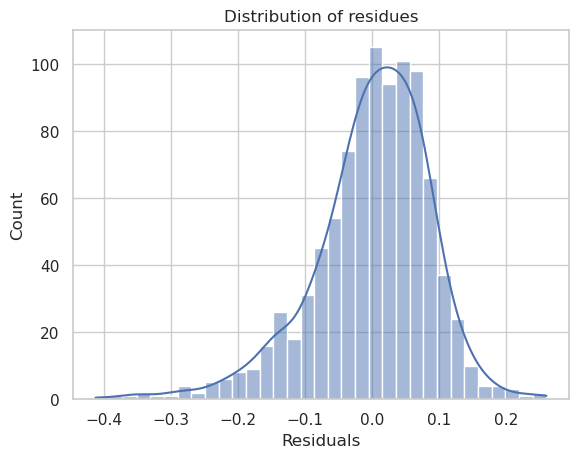

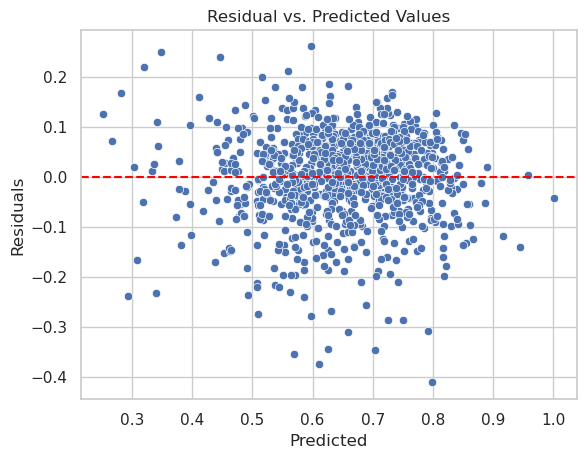

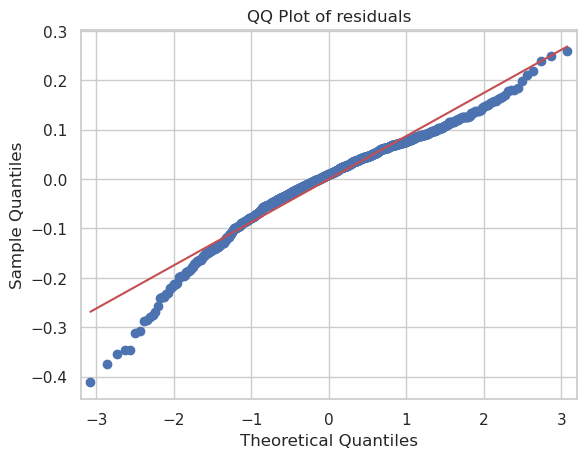

In [15]:
residuals = model_back.resid
fitted = model_back.fittedvalues

sns.histplot(residuals, kde=True)
plt.title("Distribution of residues")
plt.xlabel("Residuals")
plt.show()

sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residual vs. Predicted Values")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

sm.qqplot(residuals, line='s')
plt.title("QQ Plot of residuals")
plt.show()

## Model Evaluation on Unseen Data: Predictive Inference and Generalization

In this section, we evaluate the predictive capabilities of the final regression model on a previously unseen image. This simulates a realistic application scenario in which image quality must be estimated solely based on its visual features, without direct access to ground truth.

Using the final model obtained via forward selection, we predict the **SSIM_motion** score for a specific test image. The model provides not only a point estimate (mean predicted value), but also confidence and prediction intervals that quantify uncertainty in different ways:

- The **confidence interval (95%)** reflects the uncertainty around the model's mean prediction. It provides a range in which the expected average SSIM would fall for similar images.
- The **prediction interval (95%)** is wider and captures the expected range for a single new observation, accounting for both model uncertainty and inherent variability in the data.

In the presented example, the results are as follows:

- **Observed SSIM**: 0.788  
- **Predicted SSIM**: 0.731  
- **95% Confidence Interval**: [0.705, 0.757]  
- **95% Prediction Interval**: [0.556, 0.906]

The observed value lies well within both intervals, indicating that the model has produced a robust and reliable estimate for this particular instance. The close match between the predicted and actual SSIM also suggests good generalization performance for the tested image.

To visually assess model behavior, we plot both the true and predicted SSIM values against two key features: `canny_edge_density` and `sobel_edge_strength`. These scatterplots show that predicted values (in black) align reasonably well with the distribution of true values (in blue), although some dispersion is observed. This is expected due to the inherent noise in the data and limitations of the linear model.

Overall, the results confirm that the model can effectively estimate image quality based on interpretable features. The prediction intervals further support the model’s applicability in real-world scenarios by quantifying the range of plausible outcomes.


In [16]:
from common.config import DEMO_IMAGE_KEY

demo_image = df.loc[df['key'] == DEMO_IMAGE_KEY]

x_demo = {}

# Create input vector including dummy variables for categories
for category in model_back.model.exog_names:
    if category in features:
        x_demo[category] = demo_image[category].iloc[0]
    else:
        x_demo[category] = 1 if demo_image['category'].iloc[0] == category else 0

input_df_demo = pd.DataFrame([{**x_demo}])
input_df_demo["const"] = 1.0

pred_demo = model_back.get_prediction(input_df_demo)
pred_demo.summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,0.726244,0.013374,0.699997,0.752491,0.551237,0.901251


In [17]:
df.loc[df["key"] == DEMO_IMAGE_KEY, f"{METRIC}_motion"]

496    0.788065
Name: ssim_motion, dtype: float64

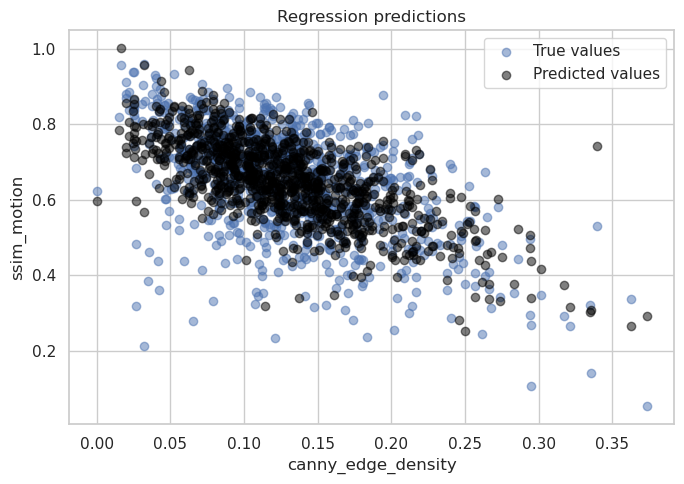

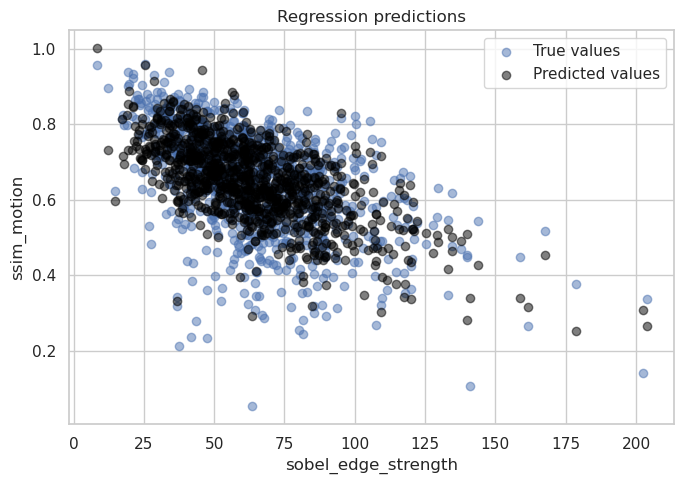

In [18]:
import matplotlib.pyplot as plt

predictions = model_back.predict(X[model_back.model.exog_names])

plt.figure(figsize=(7, 5))
plt.scatter(X['canny_edge_density'], y, alpha=0.5, label='True values')
plt.scatter(X['canny_edge_density'], predictions, c='black', alpha=0.5, label='Predicted values')
plt.title('Regression predictions')
plt.xlabel('canny_edge_density')
plt.ylabel('ssim_motion')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
plt.scatter(X['sobel_edge_strength'], y, alpha=0.5, label='True values')
plt.scatter(X['sobel_edge_strength'], predictions, c='black', alpha=0.5, label='Predicted values')
plt.title('Regression predictions')
plt.xlabel('sobel_edge_strength')
plt.ylabel('ssim_motion')
plt.legend()
plt.tight_layout()
plt.show()

## 9. Conclusions and Implications of the Regression Analysis

We conclude the analysis by synthesizing the key empirical findings and statistical insights regarding the prediction of deblurring quality, as measured by the SSIM_motion metric.

The most relevant visual features identified through regression modeling include canny_edge_density, motion_length, and sobel_edge_strength, alongside image size dimensions such as size, width, and height. These variables demonstrate significant associations with the SSIM score and consistently appear in the final optimized models.

Regarding image content, some categories—notably scenery, complex, and withchar—are associated with systematically lower SSIM values. This suggests that the type of image plays a modest yet non-negligible role in influencing deblurring performance, likely due to structural complexity or fine texture patterns.

The most comprehensive regression model, combining both numerical and categorical variables, achieves an R² of 0.606, indicating that approximately 60.6% of the variance in SSIM_motion can be explained. However, not all predictors contribute meaningfully. Through forward feature selection, an optimized subset of 16 variables was identified, yielding a nearly identical adjusted R² of 0.598, thus achieving comparable predictive accuracy with improved parsimony.

The model has demonstrated the ability to generalize well to unseen data. On a new test image, the predicted SSIM value was close to the observed value and fell well within the calculated confidence and prediction intervals, confirming the model's reliability.

Finally, diagnostic analysis of the residuals supports the validity of the linear regression assumptions. The residuals are approximately normally distributed, show no substantial heteroscedasticity, and are linearly related to the predictors. This reinforces the statistical soundness of the modeling approach and the robustness of the conclusions drawn.